In [16]:
import pandas as pd

train_df = pd.read_excel('./preprocess/sto_cap_train.xlsx', header=None)
test_df = pd.read_excel('./TestData.xlsx', header=None)

X_train = train_df.iloc[:, :-1]  # features ABCD
y_train = train_df.iloc[:, -1]   # label

X_test = test_df.iloc[:, :]  # no label

In [17]:
import numpy as np

class HandmadeDecisionTree:
    def __init__(self, max_depth=None, min_size=1):
        self.max_depth = max_depth
        self.min_size = min_size
        self.root = None

    # Calculate the Gini index for a split dataset
    def gini_index(self, groups, classes):
        n_instances = float(sum([len(group) for group in groups]))
        gini = 0.0
        for group in groups:
            size = float(len(group))
            if size == 0:
                continue
            score = 0.0
            for class_val in classes:
                p = [row[-1] for row in group].count(class_val) / size
                score += p * p
            gini += (1.0 - score) * (size / n_instances)
        return gini

    # Split a dataset
    def test_split(self, index, value, dataset):
        left, right = list(), list()
        for row in dataset:
            if row[index] < value:
                left.append(row)
            else:
                right.append(row)
        return left, right

    # Find the best split point given gini index
    def get_split(self, dataset):
        class_values = list(set(row[-1] for row in dataset))
        b_index, b_value, b_score, b_groups = 999, 999, 999, None
        for index in range(len(dataset[0])-1):
            for row in dataset:
                groups = self.test_split(index, row[index], dataset)
                gini = self.gini_index(groups, class_values)
                if gini < b_score:
                    b_index, b_value, b_score, b_groups = index, row[index], gini, groups
        return {'index':b_index, 'value':b_value, 'groups':b_groups}

    # Create a terminal node value
    def to_terminal(self, group):
        outcomes = [row[-1] for row in group]
        return max(set(outcomes), key=outcomes.count)

    # Create child splits for a node or make terminal
    def split(self, node, max_depth, min_size, depth):
        left, right = node['groups']
        del(node['groups'])
        if not left or not right:
            node['left'] = node['right'] = self.to_terminal(left + right)
            return
        if depth >= max_depth:
            node['left'], node['right'] = self.to_terminal(left), self.to_terminal(right)
            return
        if len(left) <= min_size:
            node['left'] = self.to_terminal(left)
        else:
            node['left'] = self.get_split(left)
            self.split(node['left'], max_depth, min_size, depth+1)
        if len(right) <= min_size:
            node['right'] = self.to_terminal(right)
        else:
            node['right'] = self.get_split(right)
            self.split(node['right'], max_depth, min_size, depth+1)

    # Build a decision tree
    def build_tree(self, train):
        self.root = self.get_split(train)
        self.split(self.root, self.max_depth, self.min_size, 1)
 
    # Make a prediction with this decision tree
    def predict(self, node, row):
        if row[node['index']] < node['value']:
            if isinstance(node['left'], dict):
                return self.predict(node['left'], row)
            else:
                return node['left']
        else:
            if isinstance(node['right'], dict):
                return self.predict(node['right'], row)
            else:
                return node['right']
    # Train
    def fit(self, X, y):
        dataset = np.column_stack((X,y))
        self.build_tree(dataset.tolist())

    def predict_row(self, row):
        return self.predict(self.root, row)
    
    # caculate accuracy
    def score(self, X, y):
        correct = 0
        for i in range(len(X)):
            if self.predict_row(X.iloc[i, :]) == y.iloc[i]:
                correct += 1
        return correct / float(len(X))


In [18]:
from sklearn.model_selection import KFold

def cross_validate(X, y, n_splits=5, max_depth=None, min_size=1, random_state=0):# set random_state to ensure reproducibility
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    scores = []
    for train_index, test_index in kf.split(X):
        train_X, test_X = X.iloc[train_index], X.iloc[test_index]
        train_y, test_y = y.iloc[train_index], y.iloc[test_index]
        
        model = HandmadeDecisionTree(max_depth=max_depth, min_size=min_size)
        model.fit(train_X, train_y)
        scores.append(model.score(test_X, test_y))
    return scores

max_depths = [1, 2, 3, 4, 5]
min_sizes = [1, 2, 5, 10]

best_score = 0
best_params = {'max_depth': None, 'min_size': 1}

for max_depth in max_depths:
    for min_size in min_sizes:
        scores = cross_validate(X_train, y_train, n_splits=5, max_depth=max_depth, min_size=min_size)
        avg_score = np.mean(scores)
        print(f"Max Depth: {max_depth}, Min Size: {min_size}, Validation Score: {avg_score}")
        if avg_score > best_score:
            best_score = avg_score
            best_params['max_depth'] = max_depth
            best_params['min_size'] = min_size

print(f"Best Parameters: {best_params}, Best Score: {best_score}")



Max Depth: 1, Min Size: 1, Validation Score: 0.625
Max Depth: 1, Min Size: 2, Validation Score: 0.625
Max Depth: 1, Min Size: 5, Validation Score: 0.625
Max Depth: 1, Min Size: 10, Validation Score: 0.625
Max Depth: 2, Min Size: 1, Validation Score: 0.9
Max Depth: 2, Min Size: 2, Validation Score: 0.9
Max Depth: 2, Min Size: 5, Validation Score: 0.9
Max Depth: 2, Min Size: 10, Validation Score: 0.9
Max Depth: 3, Min Size: 1, Validation Score: 0.925
Max Depth: 3, Min Size: 2, Validation Score: 0.925
Max Depth: 3, Min Size: 5, Validation Score: 0.925
Max Depth: 3, Min Size: 10, Validation Score: 0.925
Max Depth: 4, Min Size: 1, Validation Score: 0.925
Max Depth: 4, Min Size: 2, Validation Score: 0.9166666666666666
Max Depth: 4, Min Size: 5, Validation Score: 0.9333333333333332
Max Depth: 4, Min Size: 10, Validation Score: 0.925
Max Depth: 5, Min Size: 1, Validation Score: 0.925
Max Depth: 5, Min Size: 2, Validation Score: 0.9166666666666666
Max Depth: 5, Min Size: 5, Validation Score: 0.

In [19]:
model = HandmadeDecisionTree(max_depth=4, min_size=1)
model.fit(X_train, y_train)

# 对测试集进行预测
predictions = test_df.apply(model.predict_row, axis=1)

predictions = predictions.to_numpy()


# 输出预测结果
print(predictions)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3.
 3. 3. 3. 3. 3. 3.]


In [20]:
predictions = pd.DataFrame(predictions)
predictions.to_excel('./results/predictions.xlsx', index=False, header=False)

# PLOT

In [37]:
from sklearn.metrics import confusion_matrix, classification_report

def cross_validate(X, y, n_splits=5, max_depth=None, min_size=1, random_state=0):
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    scores = []
    best_model = None
    best_score = 0
    best_test_X = None
    best_test_y = None
    for train_index, test_index in kf.split(X):
        train_X, test_X = X.iloc[train_index], X.iloc[test_index]
        train_y, test_y = y.iloc[train_index], y.iloc[test_index]
        
        model = HandmadeDecisionTree(max_depth=max_depth, min_size=min_size)
        model.fit(train_X, train_y)
        score = model.score(test_X, test_y)
        scores.append(score)
        if score > best_score:
            best_score = score
            best_model = model
            best_test_X = test_X
            best_test_y = test_y
    return scores, best_model, best_test_X, best_test_y

max_depths = [1, 2, 3, 4, 5]
min_sizes = [1, 2, 5, 10]

best_score = 0
best_params = {'max_depth': None, 'min_size': 1}
best_model = None

for max_depth in max_depths:
    for min_size in min_sizes:
        scores, model, test_X, test_y = cross_validate(X_train, y_train, n_splits=5, max_depth=max_depth, min_size=min_size)
        avg_score = np.mean(scores)
        print(f"Max Depth: {max_depth}, Min Size: {min_size}, Validation Score: {avg_score}")
        if avg_score > best_score:
            best_score = avg_score
            best_params['max_depth'] = max_depth
            best_params['min_size'] = min_size
            best_model = model
            best_test_X = test_X
            best_test_y = test_y

print(f"Best Parameters: {best_params}, Best Score: {best_score}")

# Predict the validation set results
predictions = best_test_X.apply(best_model.predict_row, axis=1)
y_pred = predictions.to_numpy()

# Compute the confusion matrix
cm = confusion_matrix(best_test_y, y_pred)
print("Confusion Matrix:")
print(cm)

# Compute the classification report
cr = classification_report(best_test_y, y_pred)
print("Classification Report:")
print(cr)


Max Depth: 1, Min Size: 1, Validation Score: 0.625
Max Depth: 1, Min Size: 2, Validation Score: 0.625
Max Depth: 1, Min Size: 5, Validation Score: 0.625
Max Depth: 1, Min Size: 10, Validation Score: 0.625
Max Depth: 2, Min Size: 1, Validation Score: 0.9
Max Depth: 2, Min Size: 2, Validation Score: 0.9
Max Depth: 2, Min Size: 5, Validation Score: 0.9
Max Depth: 2, Min Size: 10, Validation Score: 0.9
Max Depth: 3, Min Size: 1, Validation Score: 0.925
Max Depth: 3, Min Size: 2, Validation Score: 0.925
Max Depth: 3, Min Size: 5, Validation Score: 0.925
Max Depth: 3, Min Size: 10, Validation Score: 0.925
Max Depth: 4, Min Size: 1, Validation Score: 0.925
Max Depth: 4, Min Size: 2, Validation Score: 0.9166666666666666
Max Depth: 4, Min Size: 5, Validation Score: 0.9333333333333332
Max Depth: 4, Min Size: 10, Validation Score: 0.925
Max Depth: 5, Min Size: 1, Validation Score: 0.925
Max Depth: 5, Min Size: 2, Validation Score: 0.9166666666666666
Max Depth: 5, Min Size: 5, Validation Score: 0.

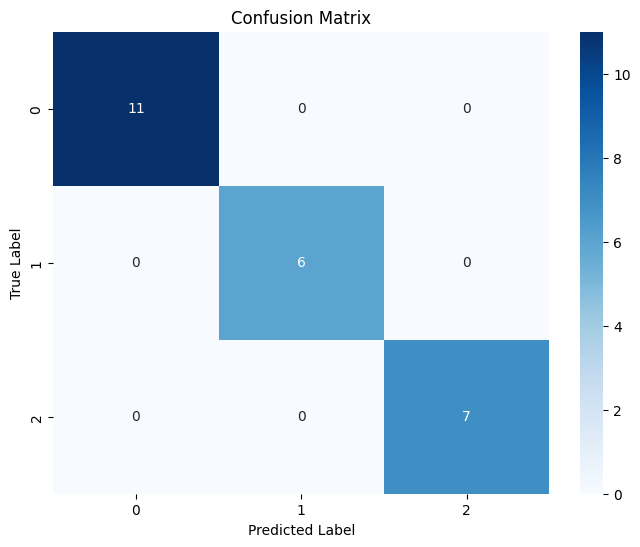

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [33]:
# Convert classification report to LaTeX table
latex_table = cr.replace('\n\n', '\n').replace('\n', '\\\\ \n').replace('     ', '&').replace('  ', '&').replace('avg', '\\hline\navg')
latex_table = '\\begin{tabular}{lcccc}\n\\hline\n' + latex_table + '\n\\hline\n\\end{tabular}'
print(latex_table)


\begin{tabular}{lcccc}
\hline
&&&&precision&&recall&f1-score& support\\ 
&& 1&&1.00& 1.00& 1.00&& 11\\ 
&& 2&&1.00& 1.00& 1.00&&&6\\ 
&& 3&&1.00& 1.00& 1.00&&&7\\ 
&&accuracy&&&&&&1.00&& 24\\ 
& macro \hline
avg&&1.00& 1.00& 1.00&& 24\\ 
weighted \hline
avg&&1.00& 1.00& 1.00&& 24\\ 

\hline
\end{tabular}


# Package Model

In [22]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=4, min_samples_split=5)

# 训练模型
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


In [23]:
y_pred = pd.DataFrame(y_pred)
y_pred.to_excel('./results/package_pred.xlsx', index=False, header=False)

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(predictions, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(predictions, y_pred))

Classification Report:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        10
         2.0       1.00      1.00      1.00        10
         3.0       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Confusion Matrix:
[[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]


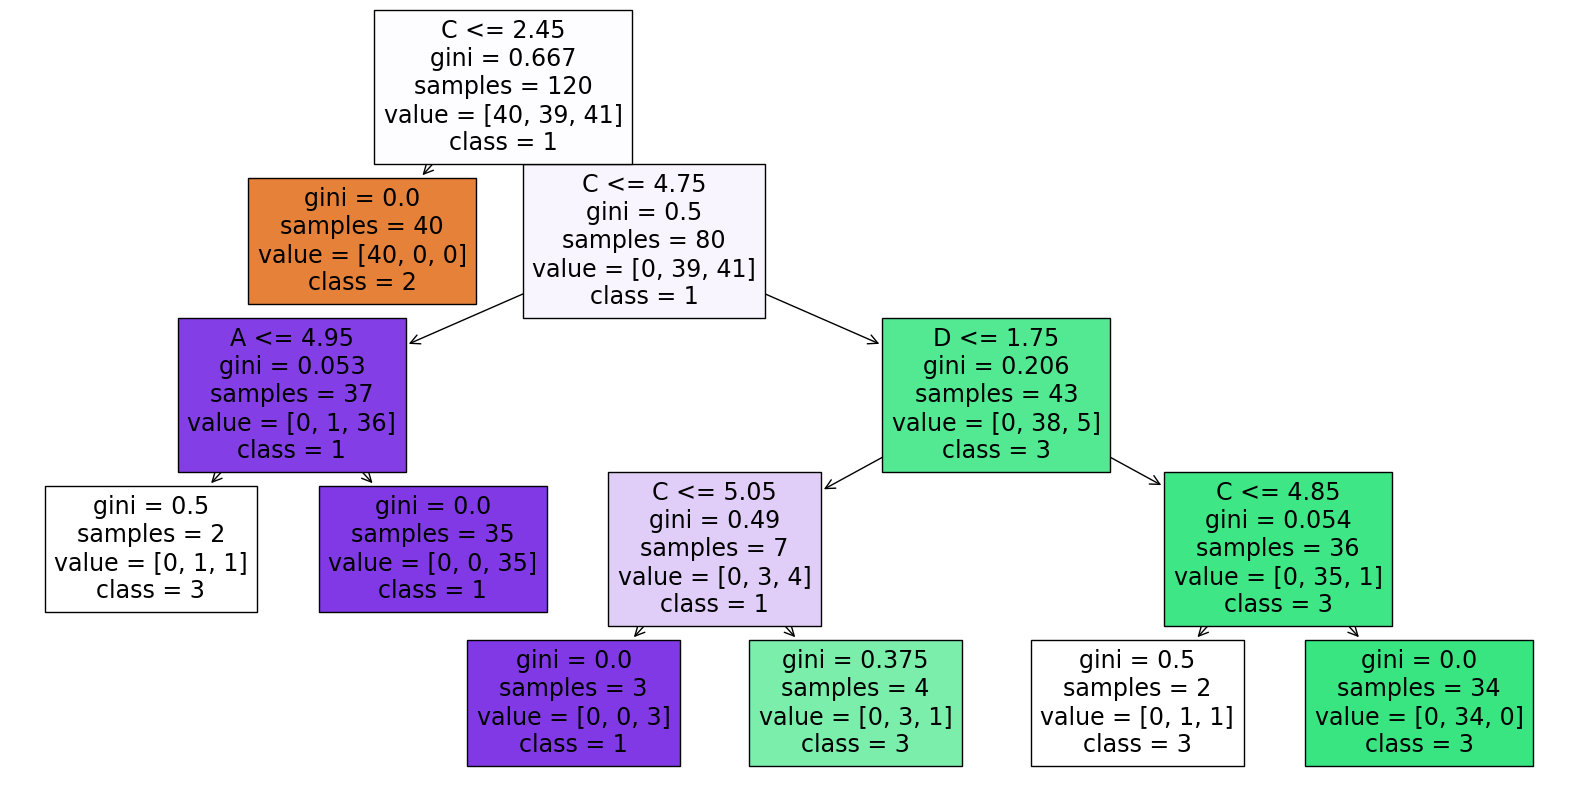

In [25]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Assign feature names
feature_names = ['A', 'B', 'C', 'D']

# Get unique class names from the last column of train_df
class_names = train_df.iloc[:, -1].unique().astype(str)

plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=feature_names, class_names=class_names)
plt.show()

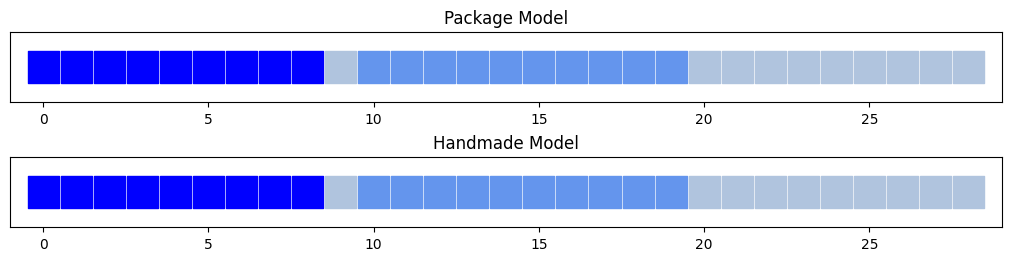

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

# 文件列表
files = ['./results/package_pred.xlsx', './results/predictions.xlsx']

# 设置画布
fig, axs = plt.subplots(len(files), 1, figsize=(10, len(files) * 1.25), constrained_layout=True)

for idx, file in enumerate(files):

    data = pd.read_excel(f'{file}')
    dataframes = pd.read_excel(file) 
    # 检查是否只有一列，如果不是，取第一列
    if len(data.columns) > 1:
        data = data[data.columns[0]]

    # 将索引作为x轴，所有值设为1作为y轴（因为我们只需要展示颜色）
    x = data.index
    y = [1] * len(data)

    # 根据值设置颜色，-1为红色，1为蓝色
    colors = ['blue' if val == 1 else 'cornflowerblue' if val == 2 else 'lightsteelblue' if val ==3  else 'black' for val in data.iloc[:, 0]]
    # 绘制散点图，s参数控制方块的大小
    axs[idx].scatter(x, y, c=colors, marker='s', s=500)

    # 移除y轴的标记
    axs[idx].get_yaxis().set_visible(False)

    # 设置x轴的范围为索引的最小和最大值，略微扩展
    axs[idx].set_xlim([x.min()-1, x.max()+1])

    if 'package' in file:
        axs[idx].set_title('Package Model')
    elif 'predictions' in file:
        axs[idx].set_title('Handmade Model')
    else:
        axs[idx].set_title(file)

plt.show()
